In [278]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from numpy import matmul as MM
from sklearn.metrics import normalized_mutual_info_score as nmi
import skcuda.linalg as LA
import skcuda
LA.init()

In [214]:
def load_dataset(name='seeds'):
    if name == 'seeds':
        with open('datasets/seeds_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.split()
                y = x[-1]
                x = x[:-1]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y
    if name == 'wine':
         with open('datasets/wine_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y  
        
    if name == 'soy':
        with open('datasets/soybean_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[-1]
                x = x[:-1]
                X.append(x)
                Y.append(int(y[-1]) - 1)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y  
    if name == 'hand':
        with open('datasets/handjob_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'olive':
        with open('datasets/olive_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y
    if name == 'symbol':
        with open('datasets/symbol_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'plane':
        with open('datasets/plane_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'mnist':
        with open('datasets/mnist_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(int(float(y)))
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y

In [215]:
def normalize_dataset(X):
    n, d = X.shape
    for i in range(d):
        mu = np.mean(X[:, i])
        std = np.std(X[:, i]) + 1e-10
        X[:, i] = (X[:, i] - mu)/std
    return X

In [295]:
# def random_V(d):
#     V_cpu = np.random.uniform(0, 1, [d, d]).astype(np.float32)
#     V_gpu = gpuarray.to_gpu(V_cpu)
# #     Q_gpu, R_gpu = LA.qr(V_gpu, mode='reduced',lib='cusolver')
#     Q,R = np.linalg.qr(V_cpu, mode='reduced')
#     Q_gpu = gpuarray.to_gpu(Q)
#     return Q_gpu

def random_V(d):
    V_cpu = np.random.uniform(0, 1, [d, d]).astype(np.float32)
    V_gpu = gpuarray.to_gpu(V_cpu)
    Q_gpu, R_gpu = LA.qr(V_gpu, mode='reduced',lib='cusolver')
    return Q_gpu

In [251]:
def projection_matrices(d, m):
    Pc = np.zeros([d, m], dtype=np.uint8)
    Pc[:m, :m] = np.eye(m, dtype=np.uint8)
    Pc = Pc.astype(np.float32)
    Pc_gpu = gpuarray.to_gpu(Pc)
    return Pc_gpu

In [315]:
def sub_kmeans(X, k):
    
    n, d = X.shape
    V_gpu = random_V(d)
    
    m = d/2
    
    X_gpu =  gpuarray.to_gpu(X) # n, d
    mu_D_gpu = skcuda.misc.mean(X_gpu, axis=0, keepdims=True) # 1, d
    
    sub_gpu = skcuda.misc.subtract(X_gpu, mu_D_gpu)
    S_D_gpu = LA.dot(sub_gpu,sub_gpu,transa='T') # d,d
    
    
    mu_is_gpu = gpuarray.to_gpu(X[np.random.choice(n, k)]) # k, d
    itr = 1
    assignment_unchanged = 0    
    
    while itr < 20:
        print(itr)
        Pc_gpu = projection_matrices(d, m) # d, m
        
        
        PcV_gpu = LA.dot(Pc_gpu,V_gpu,transa='T',transb='T') # m,d
        
        PcVmu_is_gpu = gpuarray.empty((k,m), dtype = np.float32) # k, m
        for i in xrange(k):
            PcVmu_is_gpu[i] = LA.dot(PcV_gpu,mu_is_gpu[i][:,None]).ravel() # m,d * d,1 = m
        

        X_transformed_gpu = gpuarray.empty((n,k,m),dtype=np.float32) # n, k, m
        
        for i in xrange(n):
            temp = LA.dot(PcV_gpu,X_gpu[i][:,None]).ravel()[None,:] # 1, m
            X_transformed_gpu[i] =skcuda.misc.subtract(PcVmu_is_gpu ,temp) # k, m 
        
        X_transformed_squared_gpu = LA.multiply(X_transformed_gpu,X_transformed_gpu) # n, k, m

        
        X_transformed_squared_gpu = X_transformed_squared_gpu.reshape((n*k,m))
        X_transformed_sum_gpu = skcuda.misc.sum(X_transformed_squared_gpu, axis=-1, keepdims=True)
        X_transformed_sum_gpu = X_transformed_sum_gpu.reshape((n,k))
        C_gpu = skcuda.misc.argmin(X_transformed_sum_gpu, axis=1) # n (clusters assigned)
        
        counts = gpuarray.zeros(k, dtype= np.float32) # k
        mu_is_gpu = gpuarray.zeros( (k,d), dtype= np.float32) #k,d
        
        for i in xrange(n): 
            C_id_gpu = C_gpu[i]
            C_id = np.int(C_id_gpu.get())
            mu_is_gpu[C_id] += X_gpu[i]
            counts[C_id] += 1
        
        mu_is_gpu = skcuda.misc.div_matvec(mu_is_gpu, counts[:,None]) # k, d
        
        
        S_is_gpu = gpuarray.zeros( (k, d, d), dtype= np.float32) #k,d,d
        for i in xrange(n):
            C_id_gpu = C_gpu[i]
            C_id = np.int(C_id_gpu.get())
            X_minus_mu_isi_gpu = (X_gpu[i] - mu_is_gpu[C_id])[:,None] # d, 1
            S_is_gpu[C_id] += LA.dot(X_minus_mu_isi_gpu,X_minus_mu_isi_gpu,transb='T')
        
        
        S_is_sum_gpu = S_is_gpu.reshape((k,d*d))
        S_is_sum_gpu = skcuda.misc.sum(S_is_sum_gpu, axis=0, keepdims=True)
        S_is_sum_gpu = S_is_sum_gpu.reshape((d,d))
        
        
        S_is_diff_gpu = skcuda.misc.subtract(S_is_sum_gpu, S_D_gpu)
        

        vr_gpu, w_gpu = LA.eig(S_is_diff_gpu, 'N', 'V', lib='cusolver')
        w = w_gpu.get()
        w_idx = np.argsort(w)
        
        for i in xrange(d):
            V_gpu[i] = vr_gpu[w_idx[i]]
        
        V_gpu = LA.transpose(V_gpu)
        
#         w, vr = np.linalg.eig(S_is_diff_gpu.get())
#         w_idx = np.argsort(w)
#         for i in xrange(d):
#             V_gpu[:,i] = gpuarray.to_gpu(vr[:,w_idx[i]])    
    
    
    
    
    
        maxVal = min(w)
        m = np.sum([1 for i in w if i/maxVal > 1e-3])
        m = max(1, m)
        
        itr+=1
        
        
    return C_gpu.get(), V_gpu.get(), m

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
(2, 0.7402838964654497)


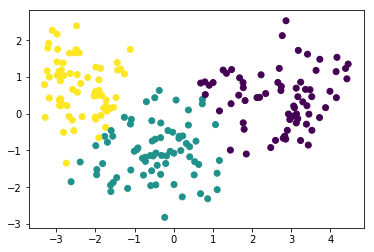

In [316]:
X, Y = load_dataset('seeds')
X = X.astype(np.float32)
X = normalize_dataset(X)
for i in range(1):
    C, V, m = sub_kmeans(X, 3)
    Pc = projection_matrices(X.shape[1], m)
    trans = V.T
    X_rotated = MM(trans[None, :, :], np.transpose(X[:, None, :], [0, 2, 1]))
    X_rotated = X_rotated.squeeze(-1).T
    acc = nmi(Y, C)
    print(m, acc)
    plt.scatter(X_rotated[0], X_rotated[1], c=C)
    plt.show()